In [231]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.stats import multivariate_normal as mvn
from scipy.stats import uniform, norm
from scipy.optimize import minimize
from tqdm import tqdm

In [2]:
data = pd.read_csv('Pantheon+SH0ES.dat', sep=' ')

z_data = data['zHD']
dm_data = data['MU_SH0ES'].values
dm_err = data['MU_SH0ES_ERR_DIAG'].values
print(data.columns)
data

Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object')


,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.88590,0.864470,0.0991,1.4960,0.0381,0.005,1.000,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.30640,0.812220,0.0971,1.4960,-0.0252,0.003,1.000,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.50000,0.000358,0.0399,0.7134,0.0545,0.019,1.000,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.12200,0.000193,0.0931,0.7134,0.0622,0.028,1.000,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.83900,0.988740,0.0567,0.6110,0.0650,0.009,1.000,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,rutledge,106,1.61505,0.00545,1.61499,0.00500,1.61399,0.00500,25.90650,0.331927,...,1.7256,8,2.92493,0.938980,0.2230,0.0106,-0.0203,0.005,1.000,0.002
1697,geta,106,1.69706,0.04006,1.69702,0.04000,1.70000,0.04000,26.03330,0.379521,...,1.8973,12,9.15387,0.689730,0.3209,0.0748,0.2680,0.005,0.633,0.000
1698,stone,106,1.80119,0.02014,1.80111,0.02000,1.80000,0.02000,26.23350,0.280685,...,1.1631,11,11.69320,0.387140,0.2370,0.0358,-0.0968,0.004,0.641,0.000
1699,wilson,106,1.91165,0.00263,1.91160,0.00100,1.91401,0.00100,26.17030,0.357624,...,1.4902,9,5.54378,0.784570,0.3168,0.0044,-0.3835,0.013,0.604,0.000


In [308]:
def f(z, cosmos):
    H_0, O_m, O_lambda = cosmos[0]
    O_K = 1 - O_m - O_lambda
    total = O_m*(1+z)**3+O_K*(1+z)**2+O_lambda
    return 1/np.sqrt(total)
    
def I(z, cosmos):
    return np.array([quad(f,0,zi, args=[cosmos])[0] for zi in z])

def r(z, cosmos):
    total = I(z, cosmos)
    return total * 3 #3 for c/H_0 in units of h^{-1}Gpc

def DM(z,cosmos):
    H_0, O_m, O_lambda = cosmos
    O_K = 1 - O_m - O_lambda
    
    flat = np.abs(O_K)
    if O_K==0:
        dm = r(z, cosmos)
    elif O_K>0:
        dm = np.sinh(r(z, cosmos)*np.sqrt(flat)/3)/np.sqrt(flat)*3
    else:
        dm = np.sin(r(z, cosmos)*np.sqrt(flat)/3)/np.sqrt(flat)*3
    dL = dm*(1+z)
    return 5*np.log10(dL * 1e9 / 10)- 5*np.log10(H_0)

In [309]:
# cosmos = (0.7, 1.0, 0.0)
cosmos = (0.7, 0.3, 0.7)

Text(0.5, 1.0, 'Hubble Diagram of Pantheon+ Data')

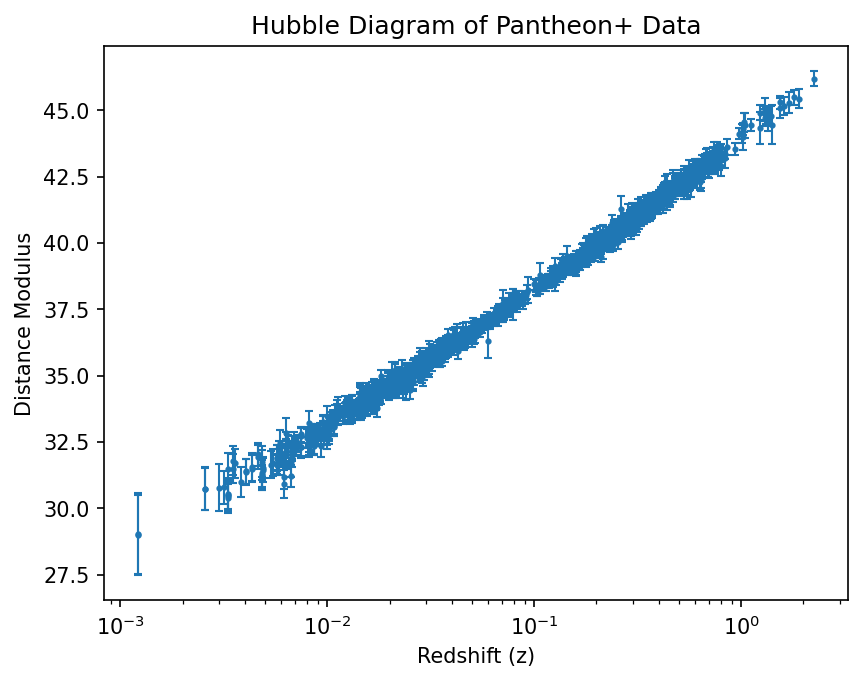

In [343]:
plt.figure(dpi=150)
plt.errorbar(z_data,dm_data,dm_err, fmt="o",markersize=2,capsize=2, linewidth=1, label="SN Data",zorder=1)
z = np.logspace(-3,0.5,201)
# plt.plot(z,DM(z, cosmos), color="orange", label=r"$h=0.7,\Omega_M=1.0,\Omega_\Lambda=0.0$",zorder=2)
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus')
plt.title('Hubble Diagram of Pantheon+ Data')
# plt.legend()

In [9]:
def chi2(cosmos):
    dm_pred = np.array([DM(z_data, cosmos)])
    deviation = (dm_pred-dm_data)/dm_err
    chi2 = np.sum(deviation**2)
    return chi2
def likelihood_ratio(cosmos1, cosmos2):
    chi2_1 = chi2(cosmos1)
    chi2_2 = chi2(cosmos2)
    return np.exp(-(chi2_1-chi2_2)/2)
cov_matrix = np.diag([1e-4,1e-3,1e-3])
def proposal_function(cosmos):
    proposal = mvn.rvs(mean=cosmos,cov=cov_matrix)
    return proposal

In [10]:
cosmos1 = (0.7, 1.0, 0.0)
cosmos2 = (0.66, 1.0, 0.0)
likelihood_ratio(cosmos1,cosmos2)

1.8696751816967435e-32

In [11]:
proposal_function(cosmos1)

array([0.71308724, 1.04003909, 0.04116008])

In [363]:
def gelman_rubin(chains, n_burn_in):
    chains_ = chains[:,n_burn_in:,:]
    chain_means = np.mean(chains_,axis=1)
    B = np.var(chain_means,axis=0)
    W = np.mean(np.var(chains_,axis=1),axis=0)
    return 1+B/W

In [13]:
def run(x0, n_chains, n_steps, n_burn_in):
    chains = np.zeros((n_chains, n_steps+1, 3))
    chains[:,0,:]=np.abs(mvn.rvs(mean=cosmos,cov=np.diag([.1,.1,.1]),size=n_chains)) 
    
    for i in tqdm(range(n_steps)):
        for j in range(n_chains):
            proposal = proposal_function(chains[j,i,:])
            r = likelihood_ratio(proposal,chains[j,i,:])
            if r>1 or uniform.rvs()<r:
                chains[j,i+1,:] = proposal
            else:
                chains[j,i+1,:] = chains[j,i,:]
    
    return chains

  0%|                                                                                                                         | 0/1000 [00:00<?, ?it/s]/var/folders/nm/n82_3x_14pq8jqsf4p9ts2bh0000gn/T/ipykernel_30953/3987520464.py:9: RuntimeWarning: overflow encountered in exp
  return np.exp(-(chi2_1-chi2_2)/2)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:38<00:00,  1.32it/s]


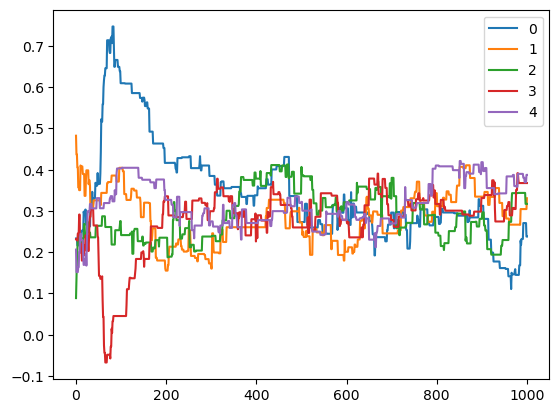

In [14]:
cov_matrix = np.diag([1e-4,1e-3,1e-3])
chains_prelim = run(cosmos1,n_chains=5,n_steps=1000,n_burn_in=500)
for i in range(5):
    plt.plot(chains_prelim[i,:,1], label=i)
plt.legend()
# plt.ylim(0.7,0.85)

In [147]:
chains_ = chains_prelim[i,500:,:]
cov_matrix = np.cov(chains_.T)#0
chains = run(cosmos1,n_chains=5,n_steps=10000,n_burn_in=500)

  0%|▏                                                                                                            | 12/10000 [00:09<2:12:44,  1.25it/s]/var/folders/nm/n82_3x_14pq8jqsf4p9ts2bh0000gn/T/ipykernel_30953/3062320737.py:5: RuntimeWarning: invalid value encountered in sqrt
  return 1/np.sqrt(total)
/var/folders/nm/n82_3x_14pq8jqsf4p9ts2bh0000gn/T/ipykernel_30953/3062320737.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return np.array([quad(f,0,zi, args=[cosmos])[0] for zi in z])
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [2:39:07<00:00,  1.05it/s]


In [366]:
#/1
differences = np.array(np.diff(chains,axis=1).flat)
rejected = np.sum(asdf==0)/len(asdf)
accepted = 1 - rejected
accepted

0.47502

In [347]:
np.save('chains.npy',chains)
np.save('chains_prelim.npy',chains_prelim)

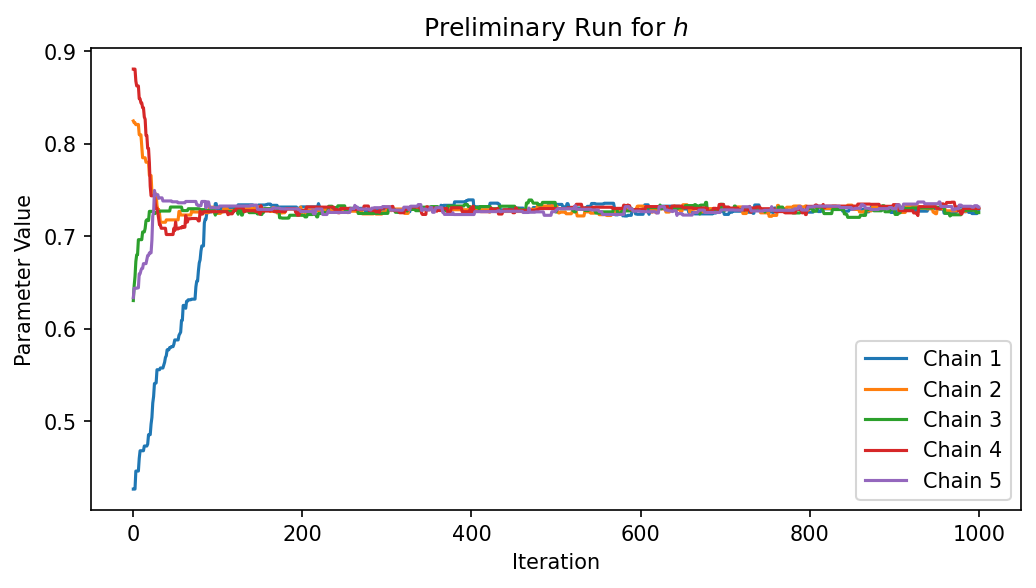

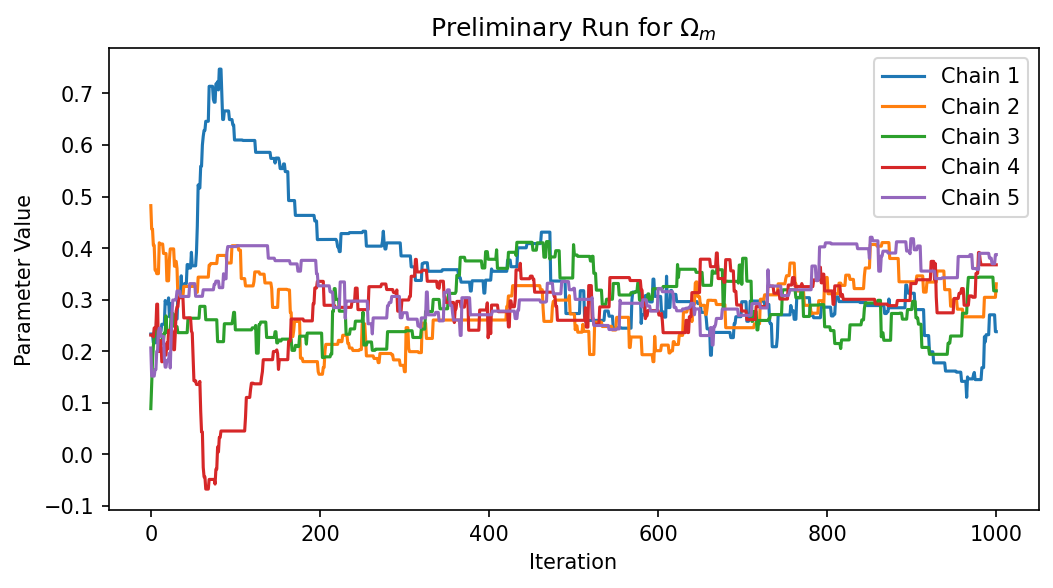

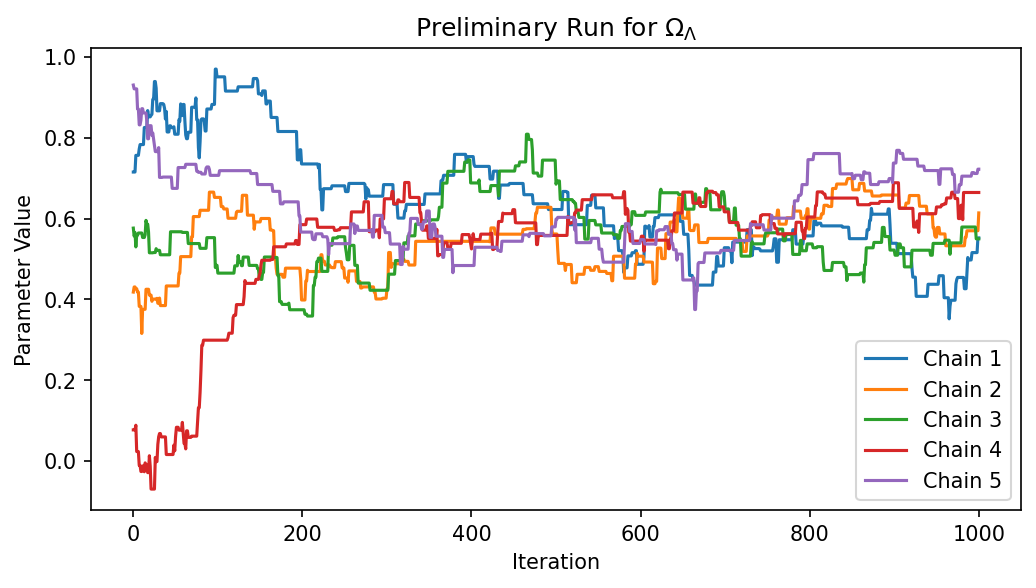

In [357]:
strings = [r'$h$',r'$\Omega_m$',r'$\Omega_\Lambda$']
for p in range(3):
    plt.figure(dpi=150, figsize=(8,4))
    for i in range(5):
        plt.plot(chains_prelim[i,:,p], label="Chain "+str(i+1))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.title(r'Preliminary Run for '+strings[p])

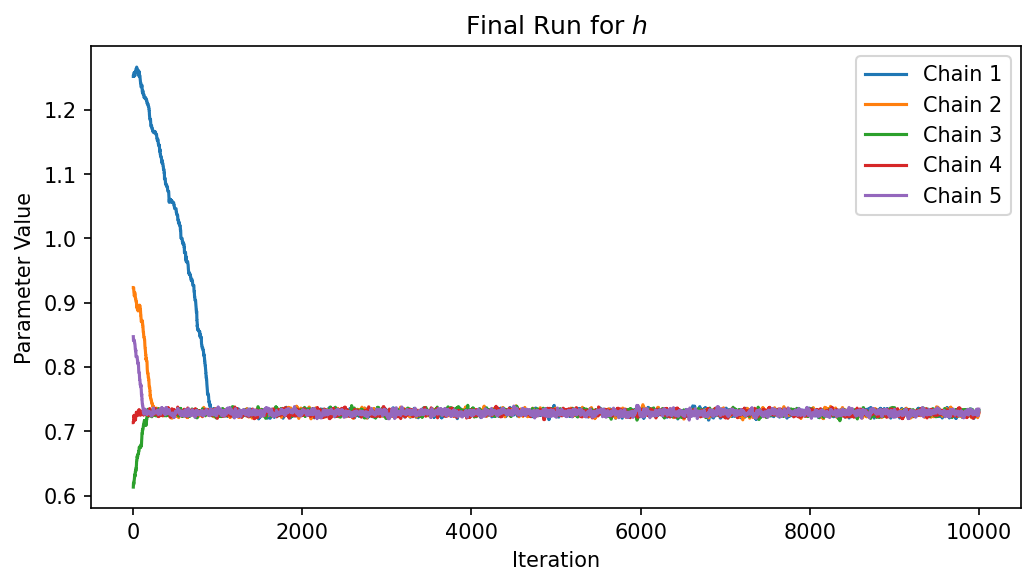

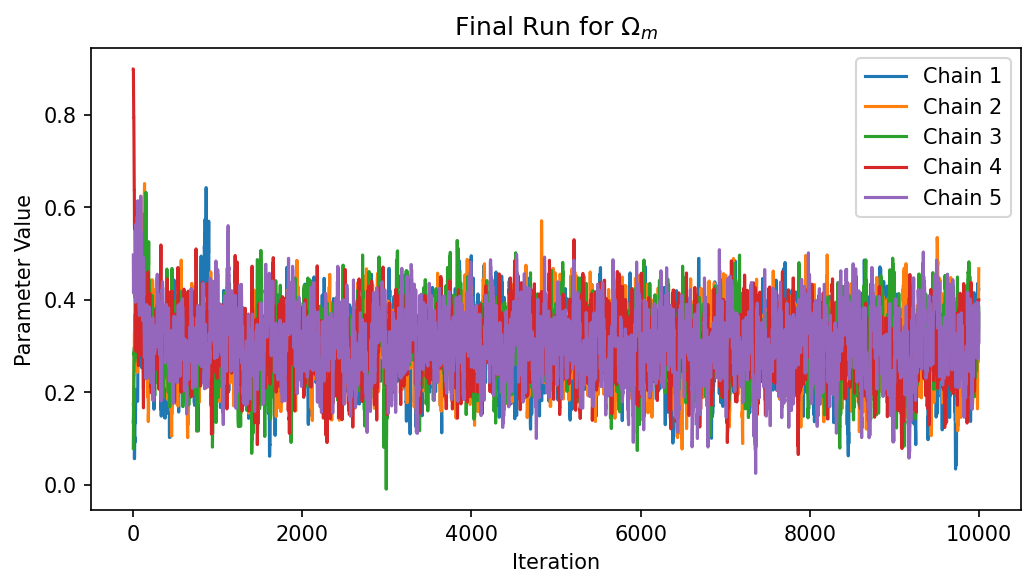

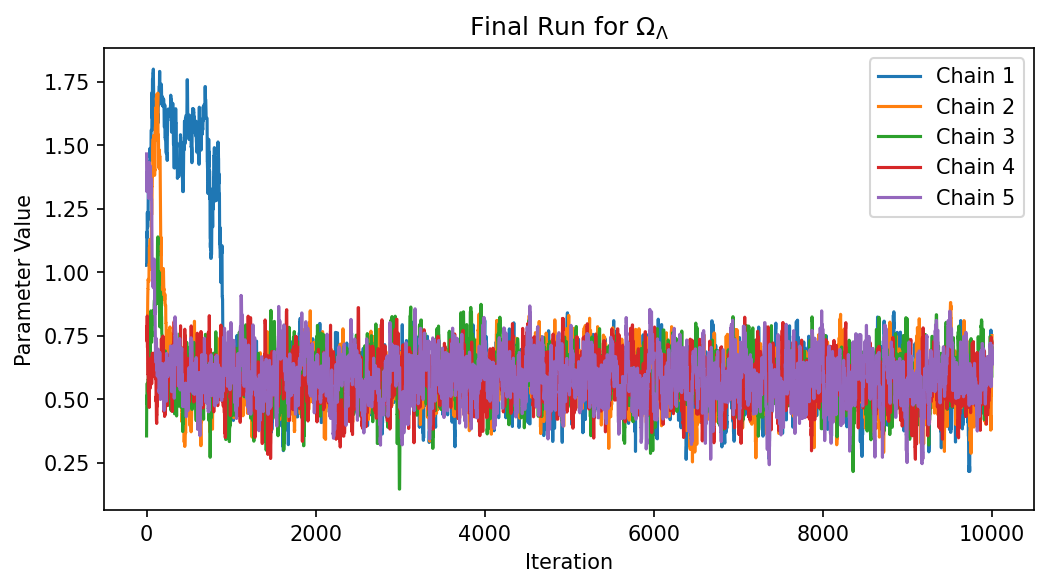

In [358]:
strings = [r'$h$',r'$\Omega_m$',r'$\Omega_\Lambda$']
for p in range(3):
    plt.figure(dpi=150, figsize=(8,4))
    for i in range(5):
        plt.plot(chains[i,:,p], label="Chain "+str(i+1))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.title(r'Final Run for '+strings[p])

In [364]:
gelman_rubin(chains[:,:,:],1000)

array([1.00252974, 1.00106214, 1.00276516])

In [268]:
def quantiles(H):
    percent_larger = []
    for l in np.arange(0,H.max()+1):
        p = np.sum(H[H>=l])/np.sum(H)
        percent_larger.append(p)
    percent_larger = np.array(percent_larger)
    qs = []
    for i in range(1,5):
        level = norm.cdf(i)*2-1
        q = np.arange(0,H.max()+1)[np.argmin(np.abs(percent_larger-level))]
        qs.append(q)
    return np.array(qs)[::-1]

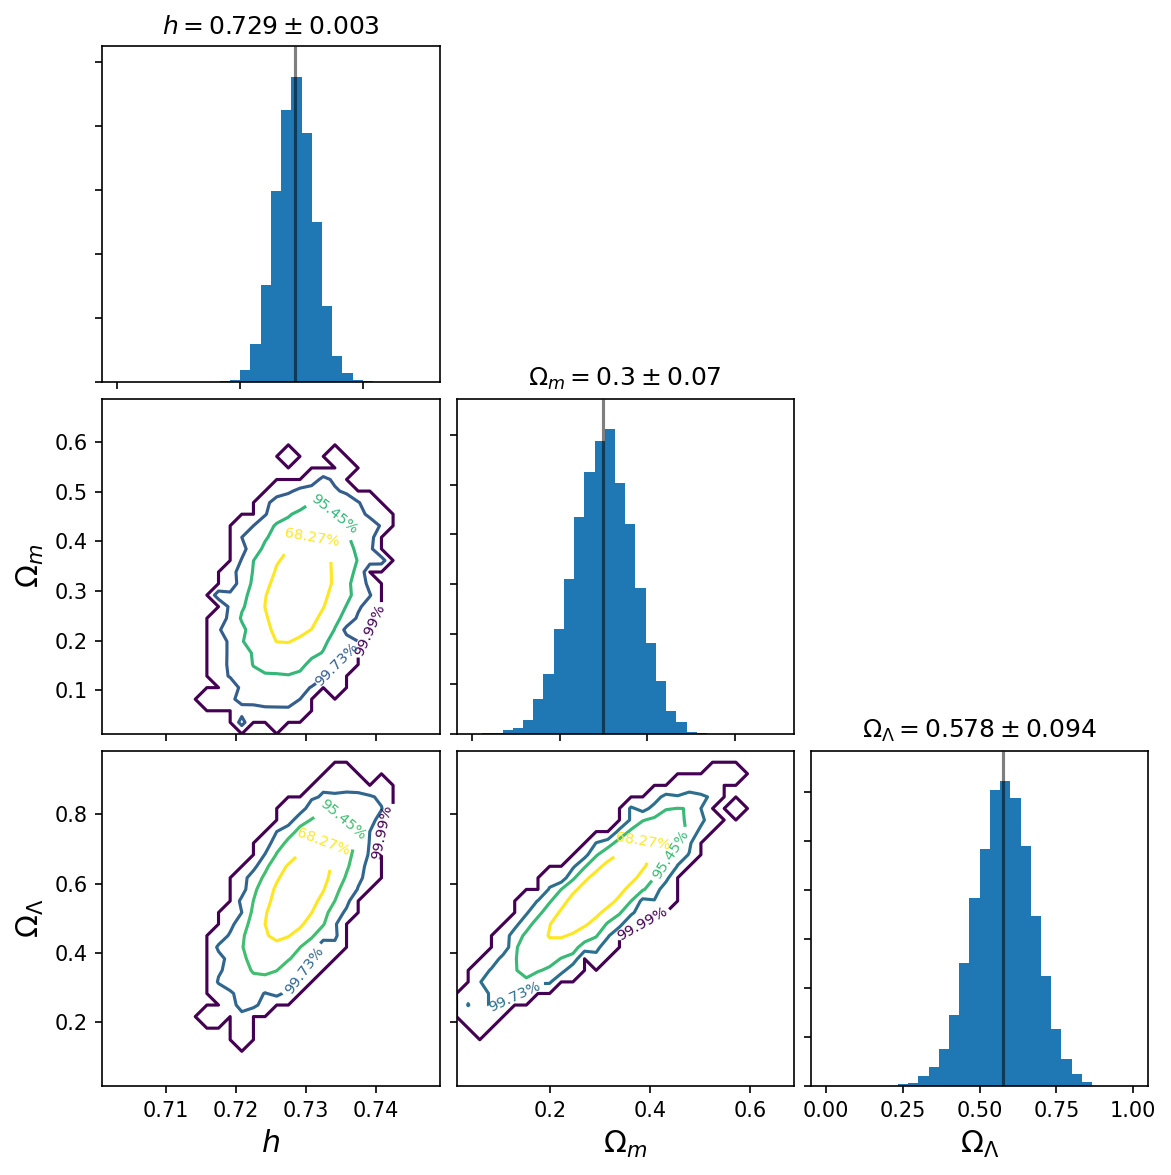

In [341]:
chains_ = chains[:,1000:,:].reshape(((10000-1000+1)*5,3))
N=31
strings = [r'$h$',r'$\Omega_m$',r'$\Omega_\Lambda$']
binss = [np.linspace(.7,.75,N),np.linspace(0,.7,N),np.linspace(0,1,N)]
fig, axs = plt.subplots(3,3,dpi=150, figsize=(9,9))
for i in range(3):
    for j in range(3):
        if i>j:
            x = chains_[:,j]
            y = chains_[:,i]
            H, xedges, yedges = np.histogram2d(x, y, bins=[binss[j],binss[i]])
            xcenters = (xedges[1:]+xedges[:-1])/2
            ycenters = (yedges[1:]+yedges[:-1])/2
            
            levels = quantiles(H)
            c = axs[i,j].contour(xcenters,ycenters,np.log(H.T+1),levels=np.log(levels+1))

            fmt = {}
            strs = [str(np.round((norm.cdf(i)*2-1)*100,2))+"%" for i in range(1,5)][::-1]
            for l, s in zip(c.levels, strs):
                fmt[l] = s

            axs[i,j].clabel(c, c.levels[::], inline=True, inline_spacing=2, fmt=fmt, fontsize=7)
            
            if i<2:
                axs[i,j].xaxis.set_ticklabels([])
            else:
                axs[i,j].set_xlabel(strings[j], fontsize="x-large")
            if j>0:
                axs[i,j].yaxis.set_ticklabels([])
            else:
                axs[i,j].set_ylabel(strings[i], fontsize="x-large")
        elif i==j:
            n, bins, _ = axs[i,j].hist(chains_[:,i], bins=binss[i])
            mean = chains_[:,i].mean()
            axs[i,j].set_title(strings[i]+r"$="+str(np.round(mean,3))+r"\pm"+str(np.round(chains_[:,i].std(),3))+"$")
            axs[i,j].vlines(mean,0,n.max()*1.1, color="k", alpha=0.5)
            axs[i,j].set_ylim(0,n.max()*1.1)
            axs[i,j].yaxis.set_ticklabels([])
            if i==2:
                axs[i,j].set_xlabel(strings[j], fontsize="x-large")
            else:
                axs[i,j].xaxis.set_ticklabels([])
        else:
            axs[i,j].axis('off')
plt.subplots_adjust(wspace=0.05,hspace=0.05)